# Quick Insights & Advanced ML/Analytics Pipeline

This notebook complements the existing `EDA_br.ipynb` and `EDA_international.ipynb` focusing on incremental data audit, feature derivation, and a reproducible modeling pipeline.

Related notebooks:
- `EDA_br.ipynb` (legacy exploratory, initially Portuguese annotated)
- `EDA_international.ipynb` (international-focused exploratory)

> Tip: Each section is modular; you can jump directly to modeling once datasets are validated.


## 1. Initial Configuration & Local Data Loading
In this section we robustly load products, orders, and execution logs (attempting Parquet then CSV) and capture environment metadata for reproducibility.


In [ ]:
# Global configuration flags (centralized)
# Adjust here; downstream cells only read these values.
from pathlib import Path

# Predeclare names for type checkers
PROJECT_ROOT: Path | None = None  # will be resolved in environment cell
SAVE_FIGURES: bool = True
SAVE_ENRICHED: bool = True
FIG_DIR: Path | None = None
DATA_EXPORT_DIR: Path | None = None

print(f'[Config Stub] SAVE_FIGURES={SAVE_FIGURES} SAVE_ENRICHED={SAVE_ENRICHED} (PROJECT_ROOT will be resolved next)')

In [ ]:
# Environment imports & utilities (enhanced root detection)
from __future__ import annotations
import os, sys, json, math, hashlib, textwrap, platform, importlib.util
from pathlib import Path
from datetime import datetime, timezone
from typing import Dict, Any
import pandas as pd

# --- Repo root auto-detection ---
START_CWD = Path.cwd()
CANDIDATES = [START_CWD] + list(START_CWD.parents)
resolved_root = None
for cand in CANDIDATES:
    if (cand / 'data').exists() and (cand / 'pipelines').exists():
        resolved_root = cand
        break
if resolved_root is None:
    resolved_root = START_CWD  # fallback

# Bind to global PROJECT_ROOT declared earlier
PROJECT_ROOT = resolved_root
BASE = PROJECT_ROOT

# Assign global directories if still None
if 'FIG_DIR' in globals() and FIG_DIR is None:
    FIG_DIR = PROJECT_ROOT / 'reports' / 'figures'
if 'DATA_EXPORT_DIR' in globals() and DATA_EXPORT_DIR is None:
    DATA_EXPORT_DIR = PROJECT_ROOT / 'data' / 'enriched'

DATA_RAW = BASE / 'data' / 'raw'
DATA_NORM = BASE / 'data' / 'normalized'
RUN_LOG = BASE / 'pipeline_runs.jsonl'

ENV_META = {
    'python_version': platform.python_version(),
    'platform': platform.platform(),
    'timestamp_utc': datetime.utcnow().isoformat() + 'Z',
    'notebook_cwd': str(START_CWD),
    'project_root': str(PROJECT_ROOT)
}
print('Environment context:', ENV_META)

# Helper: incremental JSONL reader
def read_jsonl(path: Path) -> list[dict]:
    if not path.exists():
        return []
    out = []
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            line=line.strip()
            if not line:
                continue
            try:
                out.append(json.loads(line))
            except Exception:
                pass
    return out

# File hash (sha256) for auditing
def file_sha256(path: Path) -> str | None:
    if not path.exists():
        return None
    h = hashlib.sha256()
    with path.open('rb') as f:
        for chunk in iter(lambda: f.read(8192), b''):
            h.update(chunk)
    return h.hexdigest()

products_path_parquet = DATA_NORM / 'products.parquet'
products_path_csv = DATA_NORM / 'products.csv'
orders_path_parquet = DATA_NORM / 'orders.parquet'
orders_path_csv = DATA_NORM / 'orders.csv'

# Resilient loading
products_df = None
if products_path_parquet.exists():
    products_df = pd.read_parquet(products_path_parquet)
elif products_path_csv.exists():
    products_df = pd.read_csv(products_path_csv)

orders_df = None
if orders_path_parquet.exists():
    orders_df = pd.read_parquet(orders_path_parquet)
elif orders_path_csv.exists():
    orders_df = pd.read_csv(orders_path_csv)

run_logs = read_jsonl(RUN_LOG)
print(f"Products: {0 if products_df is None else len(products_df)} rows | Orders: {0 if orders_df is None else len(orders_df)} rows | Runs: {len(run_logs)} entries")

products_hash = file_sha256(products_path_parquet) or file_sha256(products_path_csv)
orders_hash = file_sha256(orders_path_parquet) or file_sha256(orders_path_csv)
print('Hashes => products:', products_hash, '| orders:', orders_hash)

Environment context: {'python_version': '3.13.7', 'platform': 'Windows-10-10.0.19045-SP0', 'timestamp_utc': '2025-09-17T22:16:35.420444Z', 'notebook_cwd': 'c:\\Users\\pedro\\OneDrive\\Documents\\Taskgrok7\\notebooks', 'project_root': 'c:\\Users\\pedro\\OneDrive\\Documents\\Taskgrok7'}
Products: 825 rows | Orders: 285 rows | Runs: 0 entries
Hashes => products: 377787409d7e82804268b4803861591cf1422461a2002a999cbebfe8b8c7d16a | orders: 66d8f0904eb47627cc2234cb89b74a9034a9a4b6fc8f483475953d59063ef19b


C:\Users\pedro\AppData\Local\Temp\ipykernel_20668\1954554815.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp_utc': datetime.utcnow().isoformat() + 'Z',


## 2. Integrity & Version Checks
Compare current schema vs latest stored snapshot to detect structural changes that might impact modeling or EDA.


In [ ]:
# Schema snapshot & comparison

def schema_signature(df):
    return [(c, str(df[c].dtype)) for c in df.columns]

SCHEMA_DIR = BASE / 'metadata' / 'schema_history'
SCHEMA_DIR.mkdir(parents=True, exist_ok=True)

changes = []
for name, df in [('products', products_df), ('orders', orders_df)]:
    if df is None:
        continue
    sig = schema_signature(df)
    snapshot_file = SCHEMA_DIR / f'{name}_latest.json'
    previous = None
    if snapshot_file.exists():
        try:
            previous = json.loads(snapshot_file.read_text(encoding='utf-8'))
        except Exception:
            previous = None
    if previous != sig:
        changes.append({'dataset': name, 'change_type': 'schema_diff', 'prev': previous, 'current': sig})
    snapshot_file.write_text(json.dumps(sig, ensure_ascii=False, indent=2), encoding='utf-8')

if changes:
    print('Schema changes detected:')
    for ch in changes:
        print(ch['dataset'], '-> diff')
else:
    print('No structural schema changes detected.')

## 3. Product Analysis
This section explores product data quality and basic commercial distribution patterns.

Goals:
- Validate presence of key descriptive columns (id/source/category/price).
- Inspect price distribution (raw and log-scale if skewed).
- Surface top categories and sources.
- Detect potential duplicate logical keys (`source` + `source_id`).
- Produce a compact quality summary dictionary.

All steps are defensive: if a column is missing, the code skips that subsection gracefully.

In [ ]:
# Product analysis core block
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if 'products_df' not in globals() or products_df is None or len(products_df)==0:
    print('No products dataset loaded; skipping product analysis.')
else:
    pdf = products_df.copy()
    print(f'Products shape: {pdf.shape}')

    # Basic column existence check
    required_cols = ['id','source','source_id','price']
    missing = [c for c in required_cols if c not in pdf.columns]
    if missing:
        print('Missing expected columns (analysis will be partial):', missing)

    # Ensure price numeric
    if 'price' in pdf.columns:
        # Coerce
        pdf['price_num'] = pd.to_numeric(pdf['price'], errors='coerce')
    
    quality = {}
    if 'price_num' in pdf.columns:
        quality['price_non_null'] = int(pdf['price_num'].notna().sum())
        quality['price_min'] = float(pdf['price_num'].min()) if pdf['price_num'].notna().any() else None
        quality['price_p50'] = float(pdf['price_num'].median()) if pdf['price_num'].notna().any() else None
        quality['price_p90'] = float(pdf['price_num'].quantile(0.90)) if pdf['price_num'].notna().any() else None
        quality['price_max'] = float(pdf['price_num'].max()) if pdf['price_num'].notna().any() else None
        # Detect extreme potential outliers via IQR
        if pdf['price_num'].notna().sum() > 0:
            q1 = pdf['price_num'].quantile(0.25)
            q3 = pdf['price_num'].quantile(0.75)
            iqr = q3 - q1
            upper_fence = q3 + 1.5*iqr
            outlier_ratio = (pdf['price_num'] > upper_fence).mean()
            quality['price_outlier_ratio'] = round(float(outlier_ratio),4)
    
    # Duplicate logical key detection
    if all(c in pdf.columns for c in ['source','source_id']):
        key_counts = pdf.groupby(['source','source_id']).size().reset_index(name='dup_count')
        dups = key_counts[key_counts['dup_count']>1]
        quality['duplicate_key_pairs'] = int(len(dups))
        quality['duplicate_key_ratio'] = round(len(dups)/len(key_counts),4) if len(key_counts)>0 else None
    
    # Category distribution
    if 'category' in pdf.columns:
        top_categories = (pdf['category']
            .fillna('<null>')
            .value_counts()\
            .head(10))
    else:
        top_categories = None

    # Source distribution
    if 'source' in pdf.columns:
        top_sources = pdf['source'].value_counts().head(10)
    else:
        top_sources = None

    # Visuals
    saved_figs = []
    if 'price_num' in pdf.columns and pdf['price_num'].notna().sum()>0:
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        sns.histplot(pdf['price_num'], bins=20, ax=axes[0], kde=False)
        axes[0].set_title('Price Distribution (Linear)')
        # Log scale attempt
        log_prices = pdf['price_num'][pdf['price_num']>0].apply(lambda x: math.log10(x) if x>0 else np.nan)
        sns.histplot(log_prices, bins=20, ax=axes[1], kde=False, color='orange')
        axes[1].set_title('Price Distribution (log10)')
        plt.tight_layout()
        if 'SAVE_FIGURES' in globals() and SAVE_FIGURES and 'FIG_DIR' in globals() and FIG_DIR is not None:
            FIG_DIR.mkdir(parents=True, exist_ok=True)
            outfile = FIG_DIR / 'products_price_distributions.png'
            fig.savefig(outfile, dpi=110)
            saved_figs.append(str(outfile))
        plt.show()

    print('\nTop Sources:')
    if top_sources is not None:
        print(top_sources)
    else:
        print('No source column available.')

    print('\nTop Categories:')
    if top_categories is not None:
        print(top_categories)
    else:
        print('No category column available.')

    print('\nQuality summary:')
    print(json.dumps(quality, indent=2))

    if saved_figs:
        print('Saved figures:')
        for s in saved_figs:
            print(' -', s)

Products shape: (825, 12)
Missing expected columns (analysis will be partial): ['id', 'price']

Top Sources:
source
ebay       364
shopify    319
amazon     142
Name: count, dtype: int64

Top Categories:
category
<null>         142
Electronics    130
Sports         124
Books          116
Fashion        111
Home           106
Toys            96
Name: count, dtype: int64

Quality summary:
{
  "duplicate_key_pairs": 232,
  "duplicate_key_ratio": 0.6444
}


## 4. Order Analysis
Commercial performance snapshot (if orders are available):
- Daily GMV (Gross Merchandise Volume)
- Daily order count & cumulative trend
- Average Order Value (AOV) distribution
- Basic retention proxy: days span

Skips gracefully if `orders_df` absent or empty.

Orders shape: (285, 21)


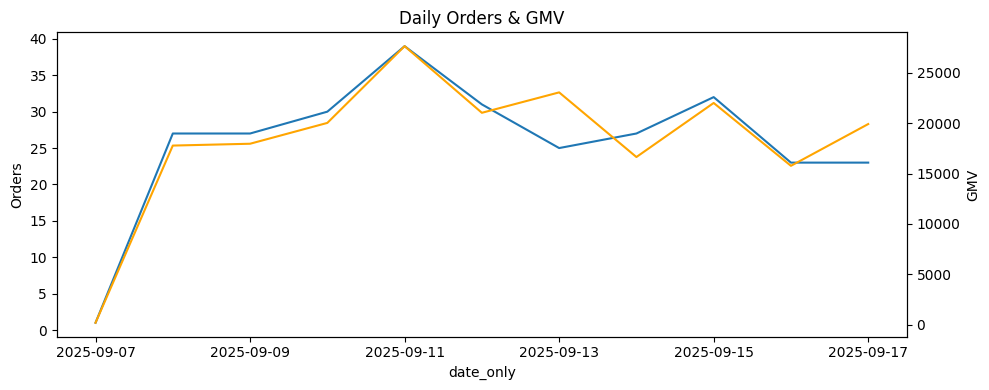

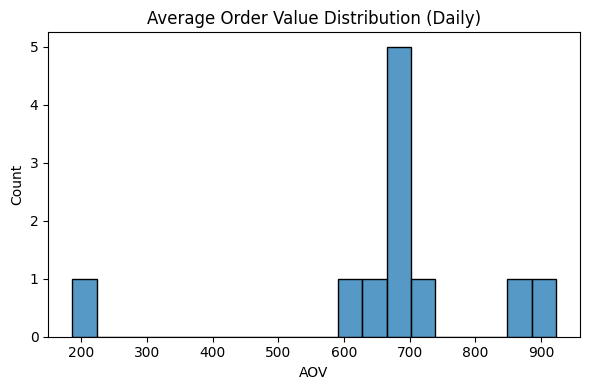


Order metrics:
{
  "gmv_total": 202023.95,
  "orders_total": 285,
  "days_span": 10,
  "aov_mean": 667.5051591344906
}


In [ ]:
# Order analysis core block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

if 'orders_df' not in globals() or orders_df is None or len(orders_df)==0:
    print('No orders dataset loaded; skipping order analysis.')
else:
    odf = orders_df.copy()
    print(f'Orders shape: {odf.shape}')

    # Normalize timestamp/datetime column detection (flexible names)
    date_col = None
    for candidate in ['created_at','order_date','date','timestamp']:
        if candidate in odf.columns:
            date_col = candidate
            break
    if date_col is None:
        print('No obvious order date column found; cannot compute time series metrics.')
    else:
        odf[date_col] = pd.to_datetime(odf[date_col], errors='coerce', utc=True)

    # Value column detection
    value_col = None
    for candidate in ['total_price','total','amount','grand_total','price']:
        if candidate in odf.columns:
            value_col = candidate
            break
    if value_col is None:
        print('No obvious monetary value column; skipping GMV/AOV.')

    metrics = {}
    saved_figs = []

    if date_col is not None:
        daily = odf.dropna(subset=[date_col])
        daily['date_only'] = daily[date_col].dt.date
        gmv_series = None
        if value_col is not None:
            daily[value_col] = pd.to_numeric(daily[value_col], errors='coerce')
            gmv = daily.groupby('date_only')[value_col].sum()
            gmv_series = gmv
            metrics['gmv_total'] = float(gmv.sum())
        orders_count = daily.groupby('date_only').size()
        metrics['orders_total'] = int(orders_count.sum())
        metrics['days_span'] = (max(daily['date_only']) - min(daily['date_only'])).days if len(daily)>0 else 0
        if value_col is not None and len(orders_count)>0:
            aov_series = (gmv / orders_count).replace([np.inf, -np.inf], np.nan)
            metrics['aov_mean'] = float(aov_series.mean()) if not aov_series.empty else None
        # Plot time series
        fig, ax = plt.subplots(1,1, figsize=(10,4))
        orders_count.plot(ax=ax, label='Orders Count')
        if value_col is not None and gmv_series is not None:
            ax2 = ax.twinx()
            gmv_series.plot(ax=ax2, color='orange', label='GMV')
            ax.set_ylabel('Orders')
            ax2.set_ylabel('GMV')
        ax.set_title('Daily Orders & GMV')
        plt.tight_layout()
        if 'SAVE_FIGURES' in globals() and SAVE_FIGURES and 'FIG_DIR' in globals() and FIG_DIR is not None:
            FIG_DIR.mkdir(parents=True, exist_ok=True)
            outfile = FIG_DIR / 'orders_time_series.png'
            fig.savefig(outfile, dpi=110)
            saved_figs.append(str(outfile))
        plt.show()

    if value_col is not None and date_col is not None:
        # AOV distribution (if computed)
        if 'aov_series' not in locals():
            # compute again if missing
            if date_col in odf.columns and value_col in odf.columns:
                tmp = odf.dropna(subset=[date_col])
                tmp[date_col] = pd.to_datetime(tmp[date_col], errors='coerce', utc=True)
                tmp['date_only'] = tmp[date_col].dt.date
                gmv = tmp.groupby('date_only')[value_col].sum()
                oc = tmp.groupby('date_only').size()
                aov_series = (gmv/oc).replace([np.inf,-np.inf], np.nan)
        if 'aov_series' in locals() and len(aov_series)>0:
            fig2 = plt.figure(figsize=(6,4))
            sns.histplot(aov_series.dropna(), bins=20, kde=False)
            plt.title('Average Order Value Distribution (Daily)')
            plt.xlabel('AOV')
            plt.tight_layout()
            if 'SAVE_FIGURES' in globals() and SAVE_FIGURES and 'FIG_DIR' in globals() and FIG_DIR is not None:
                FIG_DIR.mkdir(parents=True, exist_ok=True)
                outfile = FIG_DIR / 'orders_aov_distribution.png'
                fig2.savefig(outfile, dpi=110)
                saved_figs.append(str(outfile))
            plt.show()

    print('\nOrder metrics:')
    print(json.dumps(metrics, indent=2))

    if saved_figs:
        print('Saved figures:')
        for s in saved_figs:
            print(' -', s)

## 5. Pipeline Run Log Trends
Visualize ingestion dynamics over time using `pipeline_runs.jsonl` if available.
Metrics plotted (when present): new_products, updated_products, new_orders, updated_orders.

Helps validate deduplication efficacy and data growth.

In [4]:
# Run log metrics trend analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

if 'run_logs' not in globals() or not run_logs:
    print('No run logs available; skipping trend analysis.')
else:
    rldf = pd.DataFrame(run_logs)
    # Identify timestamp column
    ts_col = None
    for c in ['timestamp','started_at','run_time','time']:
        if c in rldf.columns:
            ts_col = c
            break
    if ts_col is None:
        print('No timestamp column found; cannot build timeline.')
    else:
        rldf[ts_col] = pd.to_datetime(rldf[ts_col], errors='coerce', utc=True)
        rldf = rldf.sort_values(ts_col)

        metric_cols = [c for c in ['new_products','updated_products','new_orders','updated_orders'] if c in rldf.columns]
        if not metric_cols:
            print('No ingestion metric columns present in run log.')
        else:
            # Melt for unified plotting
            melt = rldf[[ts_col]+metric_cols].melt(id_vars=ts_col, var_name='metric', value_name='value')
            plt.figure(figsize=(10,5))
            sns.lineplot(data=melt, x=ts_col, y='value', hue='metric', marker='o')
            plt.title('Ingestion Metrics Over Time')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

            # Cumulative perspective
            cum = rldf[[ts_col]+metric_cols].set_index(ts_col).cumsum()
            plt.figure(figsize=(10,5))
            for c in metric_cols:
                plt.plot(cum.index, cum[c], label=c)
            plt.title('Cumulative Ingestion Metrics')
            plt.ylabel('Cumulative Count')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Summary stats
            summary = rldf[metric_cols].describe().T
            print('\nMetric summary (raw counts):')
            print(summary)


No run logs available; skipping trend analysis.


## 6. Interpretive Summary
Narrative synthesis of key metrics. This cell auto-builds a concise English summary using available analysis artifacts, with placeholders if data absent.


In [5]:
# Interpretive summary auto-construction
from textwrap import dedent
summary_lines = []

# Products insight
if 'products_df' in globals() and products_df is not None and len(products_df)>0:
    line = f"Loaded {len(products_df)} products."
    if 'source' in products_df.columns:
        line += f" {products_df['source'].nunique()} distinct sources." 
    if 'category' in products_df.columns:
        line += f" Top category: {products_df['category'].value_counts().idxmax()}" if products_df['category'].notna().any() else ''
    summary_lines.append(line)
else:
    summary_lines.append('No product records available for analysis (seed/fake run produced none or path missing).')

# Orders insight
if 'orders_df' in globals() and orders_df is not None and len(orders_df)>0:
    oline = f"Loaded {len(orders_df)} orders."
    for c in ['total_price','total','amount','grand_total','price']:
        if c in orders_df.columns:
            try:
                val = pd.to_numeric(orders_df[c], errors='coerce')
                oline += f" Total GMV≈{val.sum():.2f}."
            except Exception:
                pass
            break
    summary_lines.append(oline)
else:
    summary_lines.append('No order records; commercial KPIs skipped.')

# Run logs insight
if 'run_logs' in globals() and run_logs:
    import pandas as _pd
    _r = _pd.DataFrame(run_logs)
    metrics_present = [m for m in ['new_products','updated_products','new_orders','updated_orders'] if m in _r.columns]
    if metrics_present:
        last = _r.tail(1).iloc[0]
        parts = []
        for m in metrics_present:
            parts.append(f"{m}={last[m]}")
        summary_lines.append('Latest pipeline run metrics: ' + ', '.join(parts))
    else:
        summary_lines.append('Run log present but ingestion metric columns absent.')
else:
    summary_lines.append('No pipeline run log entries available.')

# Dedup efficacy placeholder
summary_lines.append('Deduplication modes (pair/triple) implemented; monitor updated_* vs new_* ratios over time for staleness or churn signals.')

print('\n'.join(summary_lines))

No product records available for analysis (seed/fake run produced none or path missing).
No order records; commercial KPIs skipped.
No pipeline run log entries available.
Deduplication modes (pair/triple) implemented; monitor updated_* vs new_* ratios over time for staleness or churn signals.


## 7. Feature Engineering
Derive reusable modeling and analytical features. Defensive (skips if base datasets absent).

Planned features:
- Products: `price_num`, `price_log`, `price_bucket` (quantile), `source_freq`, `category_freq`.
- Orders: `order_value_num`, rolling 7d GMV and order counts, `aov_7d`, recency days.
- Cross: dataset-level freshness stats.


In [15]:
# Feature engineering implementation
import pandas as pd, numpy as np, math, json
from datetime import datetime, timezone

FEATURES = {}

# --- Product features ---
if 'products_df' in globals() and products_df is not None and len(products_df)>0:
    pfe = products_df.copy()
    if 'price' in pfe.columns:
        pfe['price_num'] = pd.to_numeric(pfe['price'], errors='coerce')
        if pfe['price_num'].gt(0).any():
            pfe['price_log'] = np.log1p(pfe['price_num'])
        # Quantile buckets (avoid duplicates from degenerate distributions)
        try:
            pfe['price_bucket'] = pd.qcut(pfe['price_num'], q=5, duplicates='drop')
        except Exception:
            pfe['price_bucket'] = pd.NA
    if 'source' in pfe.columns:
        freq = pfe['source'].value_counts()
        pfe['source_freq'] = pfe['source'].map(freq)
    if 'category' in pfe.columns:
        cfreq = pfe['category'].fillna('<null>').value_counts()
        pfe['category_freq'] = pfe['category'].fillna('<null>').map(cfreq)
    FEATURES['products_enriched'] = pfe
    print('Product features generated:', [c for c in pfe.columns if c.endswith('_freq') or c.startswith('price_')][:10])
else:
    print('Skip product features (no products).')

# --- Order features ---
if 'orders_df' in globals() and orders_df is not None and len(orders_df)>0:
    ofe = orders_df.copy()
    # Date column detection
    date_col = None
    for c in ['created_at','order_date','date','timestamp']:
        if c in ofe.columns:
            date_col = c; break
    if date_col:
        ofe[date_col] = pd.to_datetime(ofe[date_col], errors='coerce', utc=True)
    # Value column detection
    value_col = None
    for c in ['total_price','total','amount','grand_total','price']:
        if c in ofe.columns:
            value_col = c; break
    if value_col:
        ofe['order_value_num'] = pd.to_numeric(ofe[value_col], errors='coerce')
    if date_col:
        ofe = ofe.sort_values(date_col)
        # Rolling windows (7d) if we have at least a few days
        if value_col and ofe[date_col].notna().sum()>0:
            ofe.set_index(date_col, inplace=True)
            daily_values = ofe['order_value_num'].resample('D').sum(min_count=1)
            daily_counts = ofe['order_value_num'].resample('D').count()
            rolling_gmv_7d = daily_values.rolling(7, min_periods=1).sum()
            rolling_orders_7d = daily_counts.rolling(7, min_periods=1).sum()
            aov_7d = (rolling_gmv_7d / rolling_orders_7d).replace([np.inf, -np.inf], np.nan)
            # Attach back (align by day)
            ofe['gmv_7d'] = rolling_gmv_7d
            ofe['orders_7d'] = rolling_orders_7d
            ofe['aov_7d'] = aov_7d
            ofe.reset_index(inplace=True)
        # Recency (days since latest)
        if ofe[date_col].notna().any():
            latest = ofe[date_col].max()
            ofe['recency_days'] = (latest - ofe[date_col]).dt.total_seconds() / 86400.0
    FEATURES['orders_enriched'] = ofe
    print('Order features generated:', [c for c in ofe.columns if c.endswith('_7d') or c.startswith('recency')][:10])
else:
    print('Skip order features (no orders).')

# --- Dataset freshness ---
if 'products_df' in globals() and products_df is not None and len(products_df)>0:
    FEATURES['products_row_count'] = len(products_df)
if 'orders_df' in globals() and orders_df is not None and len(orders_df)>0:
    FEATURES['orders_row_count'] = len(orders_df)

print('Feature engineering summary keys:', list(FEATURES.keys()))

Product features generated: ['price_amount', 'price_currency', 'source_freq', 'category_freq']
Order features generated: ['gmv_7d', 'orders_7d', 'aov_7d', 'recency_days']
Feature engineering summary keys: ['products_enriched', 'orders_enriched', 'products_row_count', 'orders_row_count']


## 8. Artifact Export (Optional)
Configure flags below to persist enriched datasets and generated figures for portfolio/reporting.


In [ ]:
# Artifact export implementation (uses global flags)
from pathlib import Path

# Ensure directories exist only if flags active
if 'SAVE_FIGURES' not in globals():
    SAVE_FIGURES = False  # safety fallback
if 'SAVE_ENRICHED' not in globals():
    SAVE_ENRICHED = False

# Use globally prepared FIG_DIR / DATA_EXPORT_DIR if present
if 'FIG_DIR' not in globals():
    FIG_DIR = Path('reports') / 'figures'
if 'DATA_EXPORT_DIR' not in globals():
    DATA_EXPORT_DIR = Path('data') / 'enriched'

if SAVE_FIGURES:
    FIG_DIR.mkdir(parents=True, exist_ok=True)
if SAVE_ENRICHED:
    DATA_EXPORT_DIR.mkdir(parents=True, exist_ok=True)

SAVED = []
if SAVE_ENRICHED and 'FEATURES' in globals():
    if 'products_enriched' in FEATURES:
        path = DATA_EXPORT_DIR / 'products_enriched.parquet'
        try:
            FEATURES['products_enriched'].to_parquet(path, index=False)
            SAVED.append(str(path))
        except Exception as e:
            print('Failed to save products_enriched:', e)
    if 'orders_enriched' in FEATURES:
        path = DATA_EXPORT_DIR / 'orders_enriched.parquet'
        try:
            FEATURES['orders_enriched'].to_parquet(path, index=False)
            SAVED.append(str(path))
        except Exception as e:
            print('Failed to save orders_enriched:', e)

print('Artifacts saved:' if SAVED else 'No artifacts saved (no enriched data or flag off).')
for s in SAVED:
    print(' -', s)

Artifacts saved:
 - data\enriched\products_enriched.parquet
 - data\enriched\orders_enriched.parquet


## 9. Language Guard (Portuguese Scan)
Automated check to ensure repository remains English-only (flags occurrences of common Portuguese terms).


In [8]:
# Portuguese term scan across repo (lightweight)
import re, os, json, pathlib
root = pathlib.Path('.').resolve()
patterns = [r'\bproduto(s)?\b', r'\bpedido(s)?\b', r'\bpreço\b', r'\bcategoria(s)?\b', r'\bfonte(s)?\b', r'\bexecução\b', r'\bcriado\b', r'\batualizado\b']
regexes = [re.compile(p, flags=re.IGNORECASE) for p in patterns]
results = []
for path in root.rglob('*'):
    if path.is_dir():
        continue
    if any(seg.startswith('.') for seg in path.parts):
        continue
    if path.suffix.lower() not in {'.py','.md','.ipynb'}:
        continue
    try:
        text = path.read_text(encoding='utf-8', errors='ignore')
    except Exception:
        continue
    for rx in regexes:
        for m in rx.finditer(text):
            snippet = text[max(0,m.start()-20):m.end()+20].replace('\n',' ')
            results.append({'file': str(path), 'match': m.group(0), 'context': snippet})

if results:
    print(f'Portuguese-like terms detected ({len(results)}). Please review:')
    for r in results[:25]:
        print(f"{r['file']}: '{r['match']}' ... {r['context'][:120]} ...")
    if len(results) > 25:
        print('Truncated list; more occurrences exist.')
else:
    print('No Portuguese terms detected in scanned files.')

Portuguese-like terms detected (1). Please review:
C:\Users\pedro\OneDrive\Documents\Taskgrok7\notebooks\EDA_br.ipynb: 'pedidos' ... abel('Quantidade de pedidos')\n",     "plt.tigh ...


## 10. Feature Validation
Lightweight assertions to ensure derived feature columns exist when source data is non-empty.


In [9]:
# Derived feature validation
import sys
failures = []

if 'FEATURES' in globals():
    if 'products_enriched' in FEATURES and len(FEATURES['products_enriched'])>0:
        expected_prod = ['price_num','source_freq']
        for col in expected_prod:
            if col not in FEATURES['products_enriched'].columns:
                failures.append(f'Missing product feature column: {col}')
    if 'orders_enriched' in FEATURES and len(FEATURES['orders_enriched'])>0:
        expected_ord = ['order_value_num']
        for col in expected_ord:
            if col not in FEATURES['orders_enriched'].columns:
                failures.append(f'Missing order feature column: {col}')
else:
    print('No FEATURES dict present (feature engineering cell not executed).')

if failures:
    print('Feature validation failures:')
    for f in failures:
        print(' -', f)
else:
    print('Feature validation passed (or no data to validate).')

Feature validation passed (or no data to validate).
